In [1]:
import tensorflow as tf
print(tf.__version__)

2022-06-15 13:29:17.454058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


### LoadData:

In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/data.zip', compression='zip', header=0, sep=',', quotechar='"')
data["labels"] = data["sentiment"].apply(lambda x: np.where(x=="positive", 1, 0))
data.head()

,review,sentiment,labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### WordCloud:

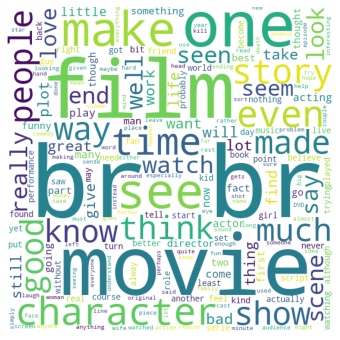

In [5]:
from data.utils import word_cloud

X, y = data["review"], data["labels"]
word_cloud(" ".join(X.tolist()))

### Tokenize sentences:

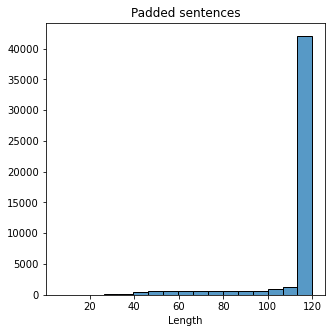

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from data.utils import hist_plot


vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences, maxlen=max_length, padding=trunc_type)
hist_plot(np.count_nonzero(padded, axis=1), "Padded sentences", "Length")

### Split data (train/test):

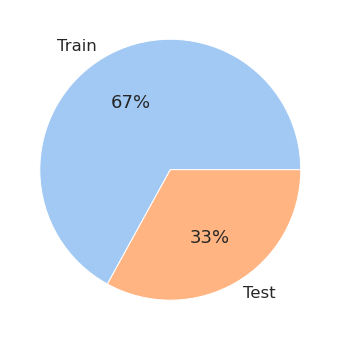

In [9]:
from sklearn.model_selection import train_test_split
from data.utils import pie_plot

split = 0.33
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=split)
pie_plot(data=[len(X_train), len(X_test)], labels=['Train', 'Test'])

### Define model with GlobalAveragePooling1D:

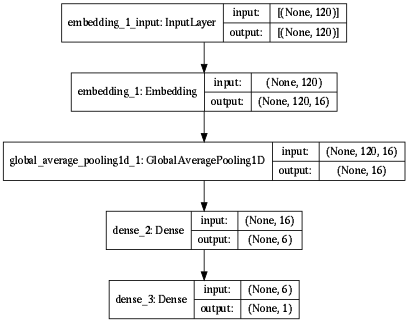

In [10]:
modelG = tf.keras.Sequential()
modelG.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
modelG.add(tf.keras.layers.GlobalAveragePooling1D())
modelG.add(tf.keras.layers.Dense(6, "relu"))
modelG.add(tf.keras.layers.Dense(1, "sigmoid"))
tf.keras.utils.plot_model(modelG, show_shapes=True, dpi=60)          

2022-06-15 13:32:02.810370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-15 13:32:02.838573: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2294510000 Hz


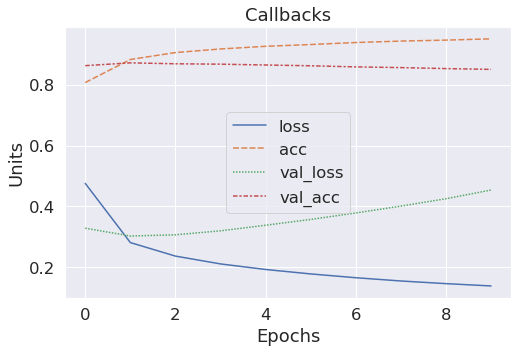

In [11]:
from data.utils import MyCallback

modelG.compile(
    optimizer="Adam", 
    loss="binary_crossentropy", 
    metrics=["acc"]
)

historyG = modelG.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[MyCallback()], 
    verbose=0
)

### Define model with Flatten:

In [ ]:
modelF = tf.keras.Sequential()
modelF.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
modelF.add(tf.keras.layers.Flatten())
modelF.add(tf.keras.layers.Dense(6, "relu"))
modelF.add(tf.keras.layers.Dense(1, "sigmoid"))
tf.keras.utils.plot_model(modelF, show_shapes=True, dpi=60) 

In [ ]:
from data.utils import MyCallback

modelF.compile(
    optimizer="Adam", 
    loss="binary_crossentropy", 
    metrics=["acc"]
)

historyF = modelF.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[MyCallback()], 
    verbose=0
)

### Files for Tensorflow Projector:

In [12]:
import os
import io

base = os.path.abspath(os.path.dirname(__name__))
vects = os.path.join(base, "data/vects.tsv")
meta = os.path.join(base, "data/meta.tsv")


reverse_word_index = {v: k for k, v in word_index.items()}

e = modelG.layers[0]
weights = e.get_weights()[0]
weights.shape

out_v = io.open(vects, "w", encoding="utf-8")
out_m = io.open(meta, "w", encoding="utf-8")
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(f"{word}\n")
    out_v.write("\t".join([f"{x}" for x in embeddings]) + "\n")
out_v.close()
out_m.close()

print(f"Paths:\n\t{vects}\n\n\t{meta}")

Paths:
	/root/PycharmProjects/Tensorflow-2.X/01 - Visualize Embeddings with Tensorflow Projector/data/vects.tsv

	/root/PycharmProjects/Tensorflow-2.X/01 - Visualize Embeddings with Tensorflow Projector/data/meta.tsv


### [Projector](http://projector.tensorflow.org/)

**Note:** Click on link and upload files from paths. 